In [1]:
import numpy as np
import matplotlib.pyplot as plt


In [2]:
# Load the data from the text file
co2 = np.loadtxt('co2.txt')

# Create X and Y arrays
X = np.vstack((co2[:, 2], np.ones(len(co2[:, 2]))))
Y = co2[:, 3]


\begin{equation}
    \begin{aligned}
        & \Sigma_{pos} = \left(\sigma^{-2} \phi\phi^\top + \Sigma_0^{-1}\right)^{-1} ,\\
        & \mu_{pos} = \Sigma_{pos}\left(\sigma^{-2}\phi y+ \Sigma_0^{-1}\mu_0\right).
    \end{aligned}
\end{equation}

In [3]:
# question 2 (a)
# Parameters
sigma = 1
sigma_0 = np.array([[100, 0], [0, 10000]])
mu_0 = np.array([0, 360])

# Calculate the posterior distribution
sigma_pos = np.linalg.inv(np.linalg.inv(sigma_0) + (1 / sigma**2) * X @ X.T)
mu_pos = sigma_pos @ (np.linalg.inv(sigma_0) @ mu_0 + (1 / sigma**2) * X @ Y)

print(sigma_pos)
print(mu_pos)

[[ 1.37479698e-05 -2.75073908e-02]
 [-2.75073908e-02  5.50396935e+01]]
[ 1.81842808e+00 -3.26615096e+03]


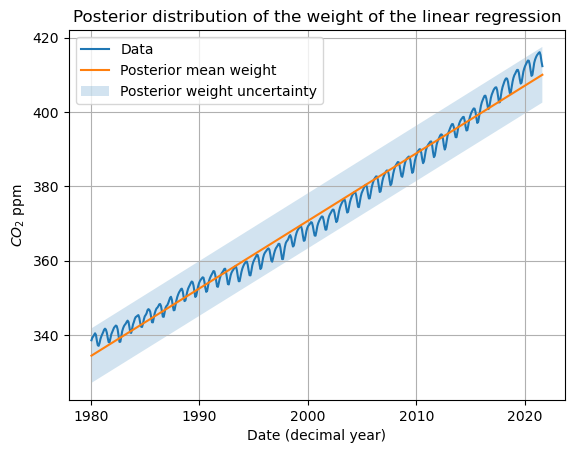

In [4]:
# Plot the data and the posterior distribution
labels = co2[:, 3]
time = co2[:, 2]

plt.plot(time, labels, label="Data")
plt.plot(time, time * mu_pos[0] + mu_pos[1], label="Posterior mean weight")
plt.fill_between(time, time * (mu_pos[0] - np.sqrt(sigma_pos[0, 0])) + mu_pos[1], time * (mu_pos[0] + np.sqrt(sigma_pos[0, 0])) + mu_pos[1], alpha=0.2, label="Posterior weight uncertainty")
plt.title("Posterior distribution of the weight of the linear regression")
plt.grid()
plt.xlabel("Date (decimal year)")
plt.ylabel("$CO_2$ ppm")
plt.legend()
# save the plot
plt.savefig("posterior_weight.png")

-0.0007252275343225847
2.6810899030117454


Text(0, 0.5, 'Residuals')

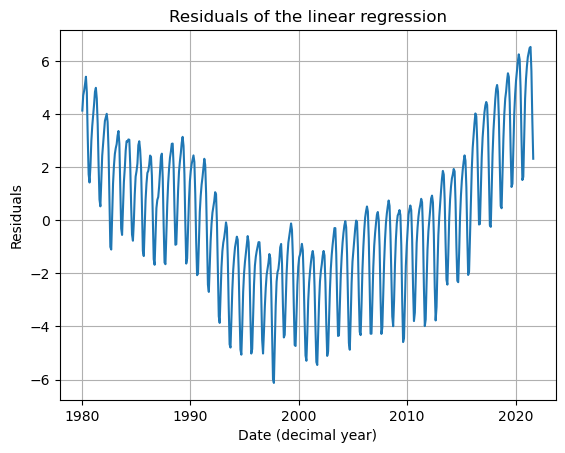

In [5]:
# question 2 (b)

residuals = Y - X.T @ mu_pos
mean_residuals = np.mean(residuals)
std_residuals = np.std(residuals)

print(mean_residuals)
print(std_residuals)

# Plot the residuals
plt.figure()
plt.plot(time, residuals)
plt.title("Residuals of the linear regression")
plt.grid()
plt.xlabel("Date (decimal year)")
plt.ylabel("Residuals")

# save the plot
# plt.savefig("residuals.png")

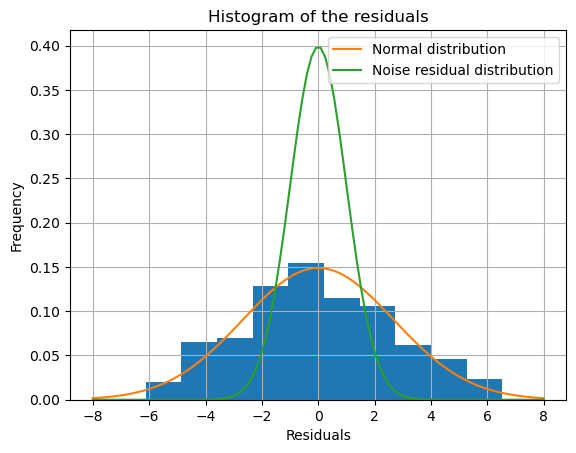

In [6]:
# histogram of the residuals
plt.figure()
plt.hist(residuals, density=True)
plt.title("Histogram of the residuals")
plt.grid()
plt.xlabel("Residuals")
plt.ylabel("Frequency")
x = np.linspace(-8, 8, 100)
y = 1 / (std_residuals * np.sqrt(2 * np.pi)) * np.exp(-0.5 * (x - mean_residuals)**2 / std_residuals**2)
plt.plot(x, y , label="Normal distribution")
y_0 = 1 / (np.sqrt(2 * np.pi)) * np.exp(-0.5 * (x)**2)
plt.plot(x, y_0, label="Noise residual distribution")
plt.legend()

# save the plot
plt.savefig("residuals_histogram.png")


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# importing the data
data = np.loadtxt("http://www.gatsby.ucl.ac.uk/teaching/courses/ml1/co2.txt")
trend = data[:, 4]
labels = data[:, 3]
time = data[:, 2]

# we concatenate the data with a  vector of ones to multiply it with the posterior weight vector.
features = np.concatenate((time[:, None], np.ones((time.shape))[:, None]), axis=1)
prior_cov = np.array([[100, 0], [0, 10000]])
prior_mean = np.array([0, 360])

# we use the derived formulae
post_cov = np.linalg.inv(features.T @ features + np.linalg.pinv(prior_cov))
post_mean = post_cov @ (features.T @ labels + np.linalg.pinv(prior_cov)@prior_mean)





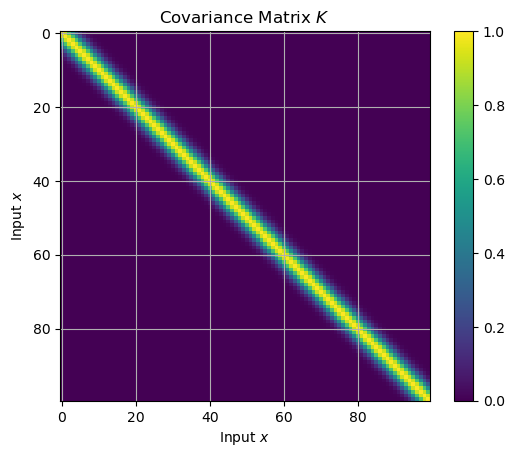

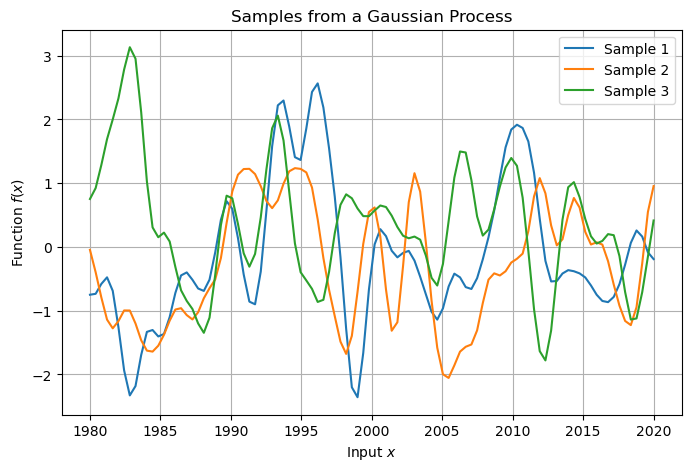

In [8]:
# question 2 (c)
import numpy as np

def gp_sample(kernel, x, n_samples=1):
    # Compute the covariance matrix K
    n = len(x)
    K = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            K[i, j] = kernel(x[i], x[j])
    
    plt.imshow(K, interpolation='nearest')
    plt.colorbar()
    plt.title('Covariance Matrix $K$')
    plt.xlabel('Input $x$')
    plt.ylabel('Input $x$')
    plt.grid()
    plt.savefig("covariance_matrix.png")
    plt.show()
    
    # Add a small noise for numerical stability
    K += 1e-8 * np.eye(n)
    
    # Draw samples from the multivariate normal distribution
    mean = np.zeros(n)
    samples = np.random.multivariate_normal(mean, K, n_samples)
    
    return samples

# define an squared exponential kernel
def squared_exponetial_kernel(x1, x2, lengthscale=1.0, variance=1.0):
    return variance * np.exp(-0.5 * (x1 - x2)**2 / lengthscale**2)

# Input points
x = np.linspace(1980, 2020, 100)

# Generate a sample from the GP
gp_samples = gp_sample(kernel=squared_exponetial_kernel, x=x, n_samples=3)

# Plot the samples
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))
for i, sample in enumerate(gp_samples):
    plt.plot(x, sample, label=f'Sample {i+1}')
plt.xlabel('Input $x$')
plt.ylabel('Function $f(x)$')
plt.title('Samples from a Gaussian Process')
plt.legend()
plt.grid()
#plt.savefig("gp_samples.png")
plt.show()




In [9]:
# question 2 (d)
def custom_kernel(s, t, theta=1.0, tau=1.0, sigma=1.0, phi=1.0, eta=1.0, zeta=1e-6):
    periodic_term = np.exp(-2 * np.sin(np.pi * (s - t) / tau)**2 / sigma**2)
    squared_exp_term = phi**2 * np.exp(-(s - t)**2 / (2 * eta**2))
    noise_term = zeta**2 if s == t else 0
    return theta**2 * (periodic_term + squared_exp_term) + noise_term

def gp_sample_custom_kernel(x, kernel, n_samples=1, **kernel_params):
    n = len(x)
    K = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            K[i, j] = kernel(x[i], x[j], **kernel_params)
    
    # Add a small jitter for numerical stability
    #K += 1e-8 * np.eye(n)
    np.random.seed(0)
    # Draw samples from the multivariate normal distribution
    mean = np.zeros(n)
    samples = np.random.multivariate_normal(mean, K, n_samples)
    
    return samples, K



In [10]:
# question 2 (d)
# vary the hyperparameters eta, tau, theta, and zeta and plot the samples and the covariance matrix

# Input points
x = np.linspace(0, 10, 100)

# Define the hyperparameter values
sigma_values = [0.1, 1, 5, 10]
phi_values = [0.01, 1, 5, 10]
eta_values = [0.1, 1, 5, 10]
tau_values = [0.1, 1.0, 2.5, 5.0]
theta_values = [0.1, 1.0, 2.5, 10.0]
zeta_values = [1e-06, 1e-05, 0.0001, 0.001]

# Function to plot samples and covariance matrix for given hyperparameter values
def plot_gp_samples_and_covariance(x, param_values, param_name):
    fig, axs = plt.subplots(2, len(param_values), figsize=(14, 7))
    for i, param in enumerate(param_values):
        samples, K = gp_sample_custom_kernel(x, custom_kernel, n_samples=1, **{param_name: param})
        
        # Plot the samples
        axs[0, i].plot(x, samples[0], label=f'{param_name}={param}')
        axs[0, i].set_xlabel('Input $x$')
        axs[0, i].set_ylabel('Function $f(x)$')
        axs[0, i].set_title(f'Samples from a GP with ${param_name}={param}$')
        axs[0, i].legend()
        axs[0, i].grid()
        
        # Plot the covariance matrix
        im = axs[1, i].imshow(K, interpolation='nearest', cmap='viridis')
        axs[1, i].set_title(f'Covariance Matrix $K$ with ${param_name}={param}$')
        axs[1, i].set_xlabel('Input $x$')
        axs[1, i].set_ylabel('Input $x$')
        axs[1, i].grid()

    plt.tight_layout()
    plt.savefig(f"gp_samples_and_covariance_matrices_{param_name}.png")
    plt.show()


# # Plot for eta
# plot_gp_samples_and_covariance(x, eta_values, 'eta')

# # Plot for tau
# plot_gp_samples_and_covariance(x, tau_values, 'tau')

# Plot for theta
# plot_gp_samples_and_covariance(x, theta_values, 'theta')

# # Plot for zeta
# plot_gp_samples_and_covariance(x, zeta_values, 'zeta')

# # Plot for sigma
# plot_gp_samples_and_covariance(x, sigma_values, 'sigma')

# # Plot for phi
# plot_gp_samples_and_covariance(x, phi_values, 'phi')

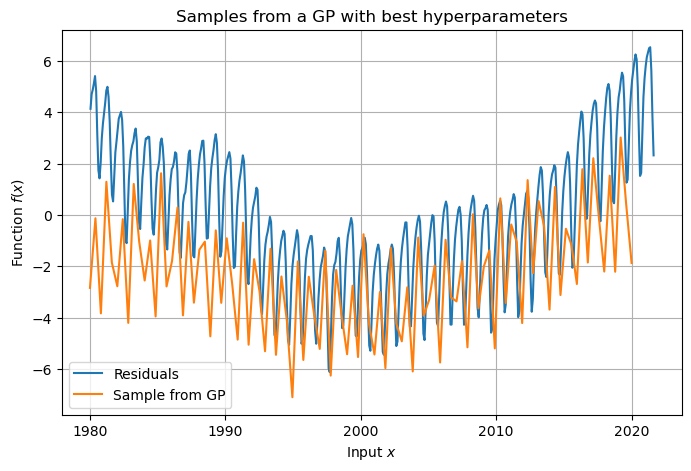

In [11]:
# question 2 (e)
# plot the samples with the best hyperparameters and compare them with residuals
# Input points
x = np.linspace(1980, 2020, 100)

samples, K = gp_sample_custom_kernel(x, custom_kernel, n_samples=1, theta=1.5, tau=1.0, sigma=1, phi=0.9, eta=9, zeta=0.5)
plt.figure(figsize=(8, 5))
plt.plot(time, residuals, label="Residuals")
plt.plot(x, samples[0], label="Sample from GP")
plt.xlabel('Input $x$')
plt.ylabel('Function $f(x)$')
plt.title('Samples from a GP with best hyperparameters')
plt.grid()
plt.legend()
plt.savefig("gp_samples_residuals.png")
plt.show()

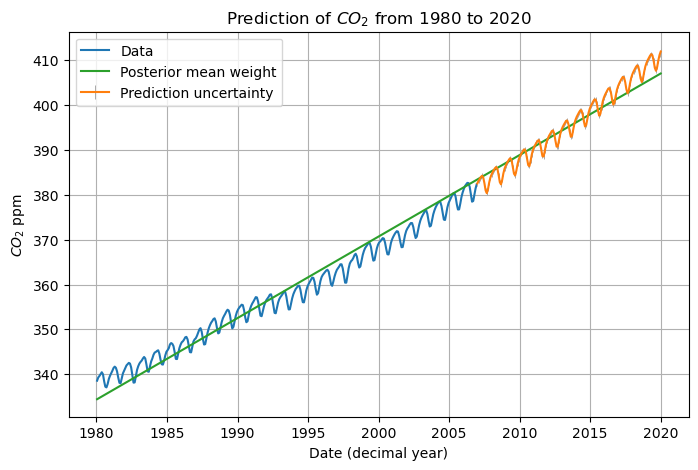

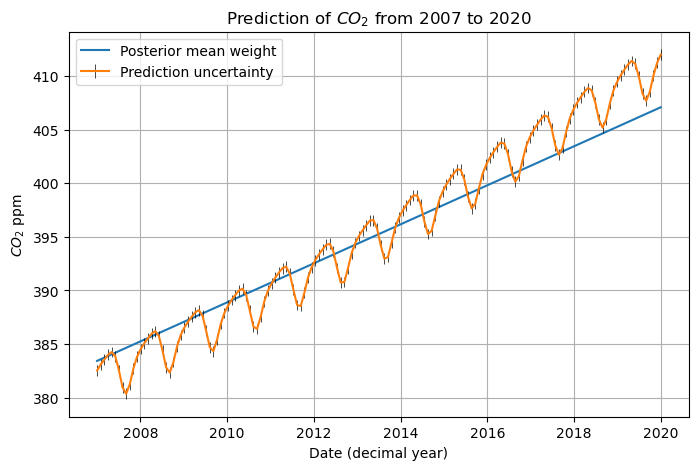

: 

In [ ]:
# question 2 (f)
# here we define the kernel function again with the parameters found in the previous question
def kernel_function(s, t):
    # vectorised Kernel function
    s = s.reshape(-1, 1)
    t = t.reshape(1, -1)
    
    theta = 1.5
    tau = 1
    sigma = 1
    phi = 0.9
    eta = 9
    zeta = 0.5

    periodic_term = np.exp(-2 * np.sin(np.pi * (s - t) / tau)**2 / sigma**2)
    squared_exp_term = phi**2 * np.exp(-(s - t)**2 / (2 * eta**2))
    noise_term = zeta**2 * (s == t)
    return theta**2 * (periodic_term + squared_exp_term) + noise_term

# we calculate the mean and covariance of the conditioned GP
x = co2[:, 2]
K = kernel_function(x, x)

# predict c02 concentration to 2020
begin = 2007
end = 2020
domain = np.linspace(begin, end, 12*(end-begin))

# calculate the mean and covariance of the conditioned GP
K_s = kernel_function(domain, x)
K_ss = kernel_function(domain, domain)
K_inv = np.linalg.inv(K)
mu_s = K_s @ K_inv @ residuals
cov_s = K_ss - K_s @ K_inv @ K_s.T

# sample from the conditioned GP - predicted residuals
samples = np.random.multivariate_normal(mu_s, cov_s, 1)

# f(t) =  a * t + b + g(t)
features = np.concatenate((domain[:, None], np.ones((len(domain)))[:, None]), axis=1)
predictions = samples + (features @ mu_pos)[:, None]
predictions_mean = mu_s + (features @ mu_pos)

z = np.linspace(min(x), end, 1000)
# plot the prediction from 1980 to 2020
plt.figure(figsize=(8, 5))
plt.plot(time[time < 2007], labels[time < 2007], label="Data")
plt.errorbar(domain, predictions_mean, yerr=np.sqrt(np.diag(cov_s)), elinewidth=0.7, ecolor="darkgrey", label="Prediction uncertainty")
plt.plot(z, z * mu_pos[0] + mu_pos[1], label="Posterior mean weight")
plt.xlabel("Date (decimal year)")
plt.ylabel("$CO_2$ ppm")
plt.title("Prediction of $CO_2$ from 1980 to 2020")
plt.grid()
plt.legend()
plt.savefig("prediction_1980_2020.png")
plt.show()

# plot the prediction from 2007 to 2020
z = np.linspace(begin, end, 1000)
plt.figure(figsize=(8, 5))
plt.plot(z, z * mu_pos[0] + mu_pos[1], label="Posterior mean weight")
plt.errorbar(domain, predictions_mean, yerr=np.sqrt(np.diag(cov_s)), elinewidth=0.5, ecolor="black", label="Prediction uncertainty")
plt.xlabel("Date (decimal year)")
plt.ylabel("$CO_2$ ppm")
plt.title("Prediction of $CO_2$ from 2007 to 2020")
plt.grid()
plt.legend()
plt.savefig("prediction_2007_2020.png")
plt.show()
